In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Attentive Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 64
batch_size = 64
num_points = 128
num_samples = 20000
n_epochs = 10


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return AttentiveNeuralProcess(x_dim, y_dim,
                                  XEncoder=MLP,
                                 attention="scaledot",
                                 XYEncoder=_DeepMLP,
                                 Decoder=_DeepMLP,
                                 r_dim=r_dim,
                                 LatentEncoder=MLP,
                                 get_cntxt_trgt=get_cntxt_trgt)


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

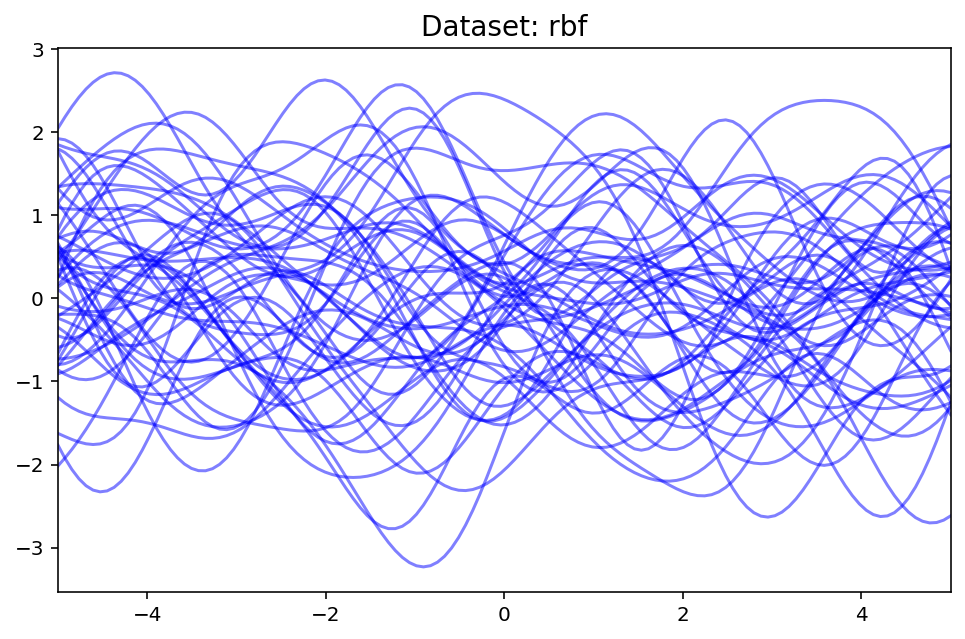

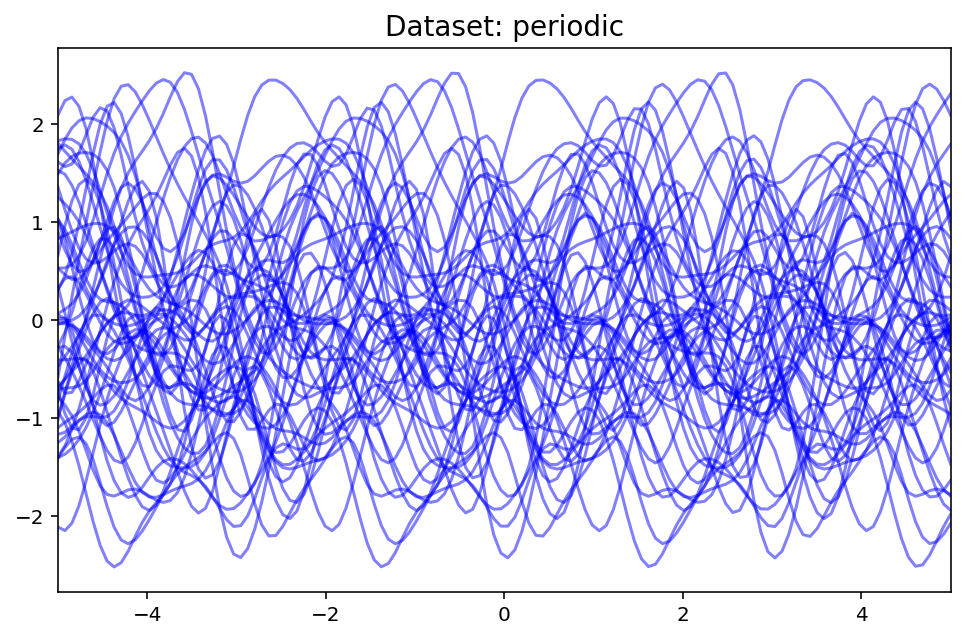

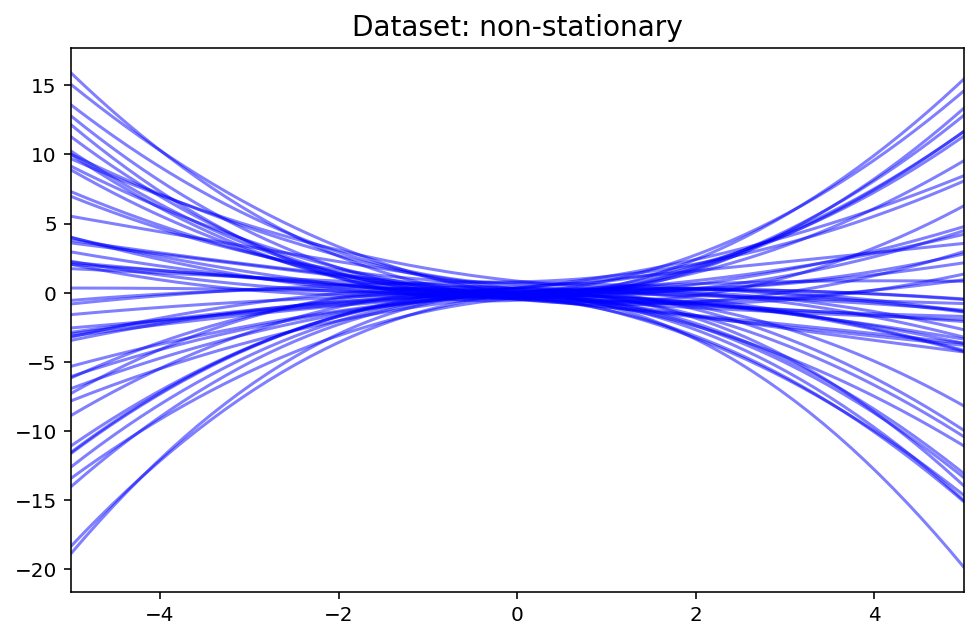

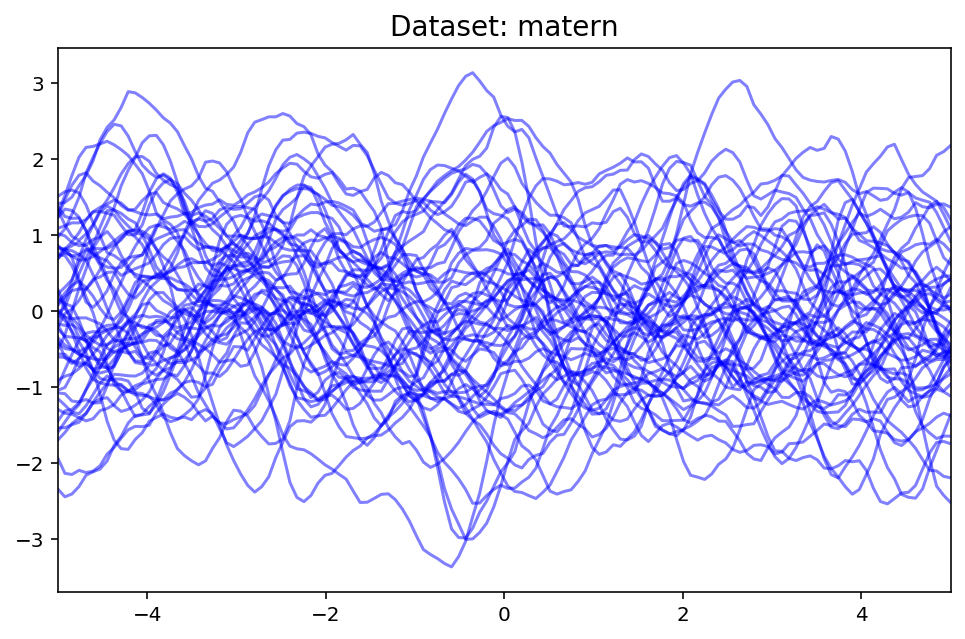

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

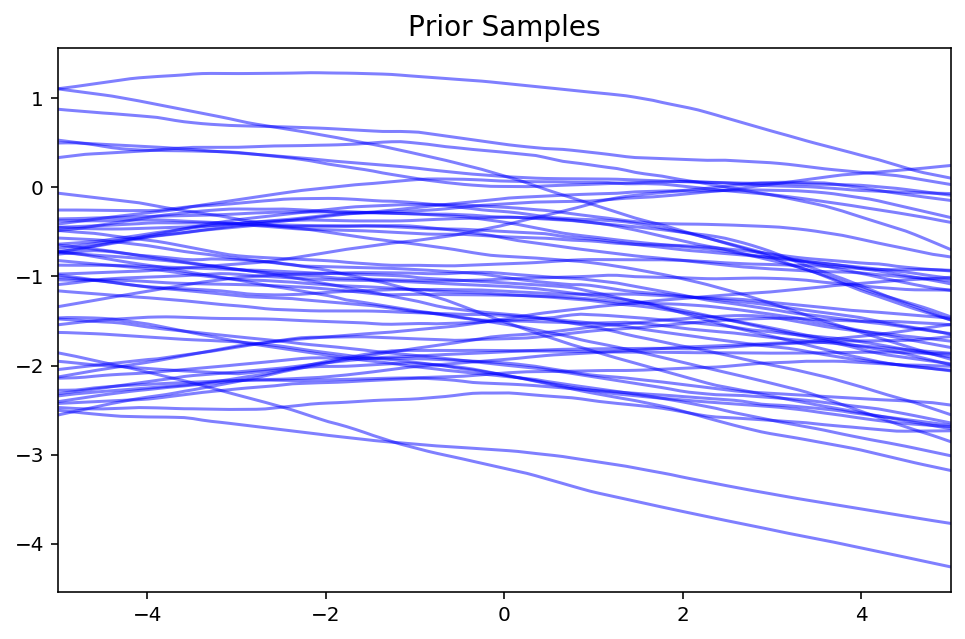

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss     dur
-------  ------------  ------
      1      187.0949  5.3453


      2      134.0259  5.5123


      3      116.3296  5.4698


      4      102.3767  5.6100


      5       85.9361  5.0620


      6       63.3383  4.5280


      7       33.0520  4.7123


      8       12.8038  5.2569


      9       -3.2506  4.1675


     10      -13.0262  5.4249

--- Training periodic ---



  epoch    train_loss     dur
-------  ------------  ------
      1      861.9923  5.0198


      2      157.5768  5.4494


      3      146.7768  4.4852


      4      142.3822  5.5126


      5      139.5062  5.5001


      6      136.8973  5.1756


      7      134.8575  4.6563


      8      134.2002  4.9927


      9      133.5362  5.2181


     10      132.7126  5.5847

--- Training non-stationary ---



  epoch    train_loss     dur
-------  ------------  ------
      1      263.4346  5.6107


      2      150.3952  4.7811


      3       69.5378  5.6043


      4       41.4260  4.8429


      5        9.5188  5.4245


      6      -19.5977  5.4678


      7      -42.1294  5.4422


      8      -49.6380  5.7274


      9      -64.3254  5.6344


     10      -76.6591  5.5904

--- Training matern ---



  epoch    train_loss     dur
-------  ------------  ------
      1      181.6267  5.1450


      2      143.1477  5.0908


      3      122.5100  4.7389


      4      100.8378  5.6354


      5       81.0162  5.1807


      6       63.3269  4.9704


      7       48.2069  4.6433


      8       44.5176  5.2378


      9       36.6613  4.9773


     10       34.0941  5.6167


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

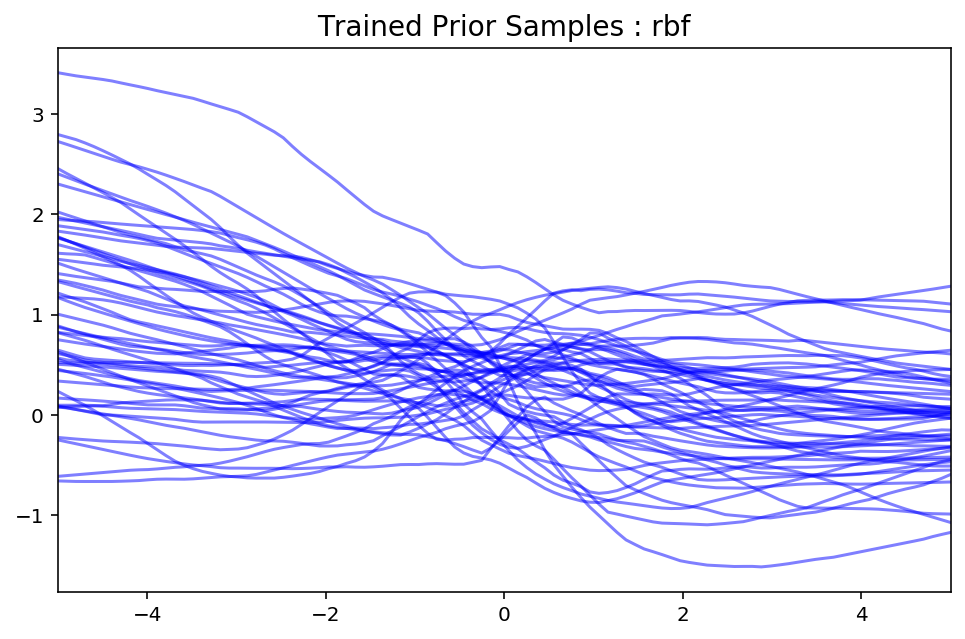

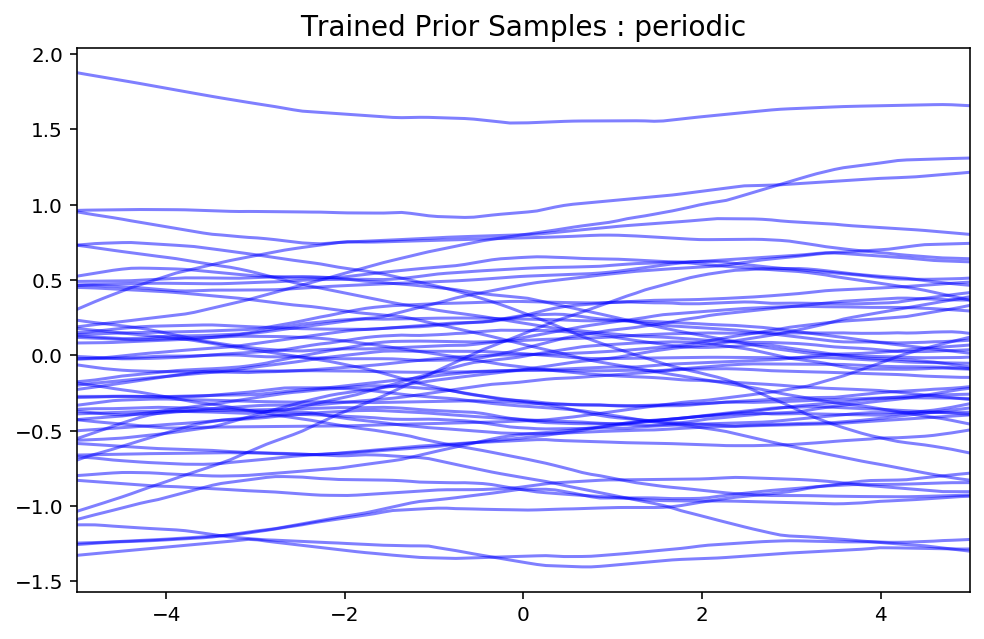

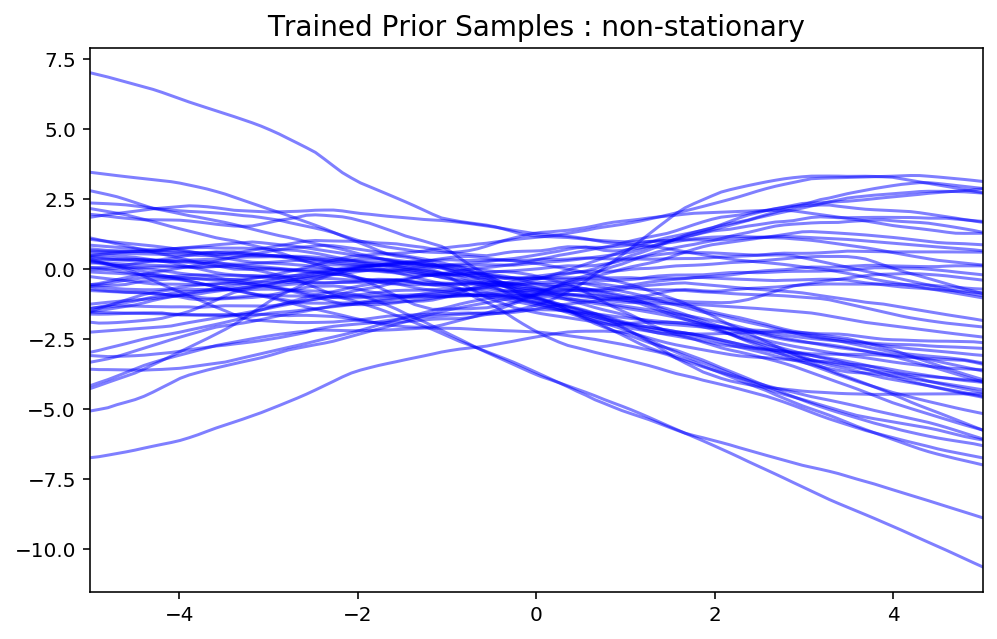

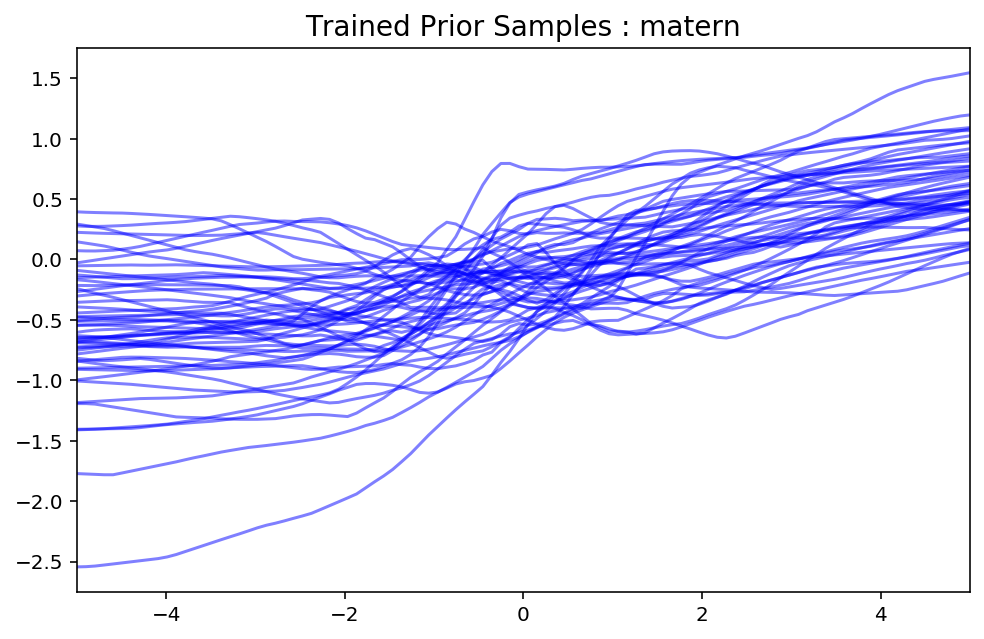

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.5122057
std: 0.5642546
std: 0.21293683
std: 0.5047919


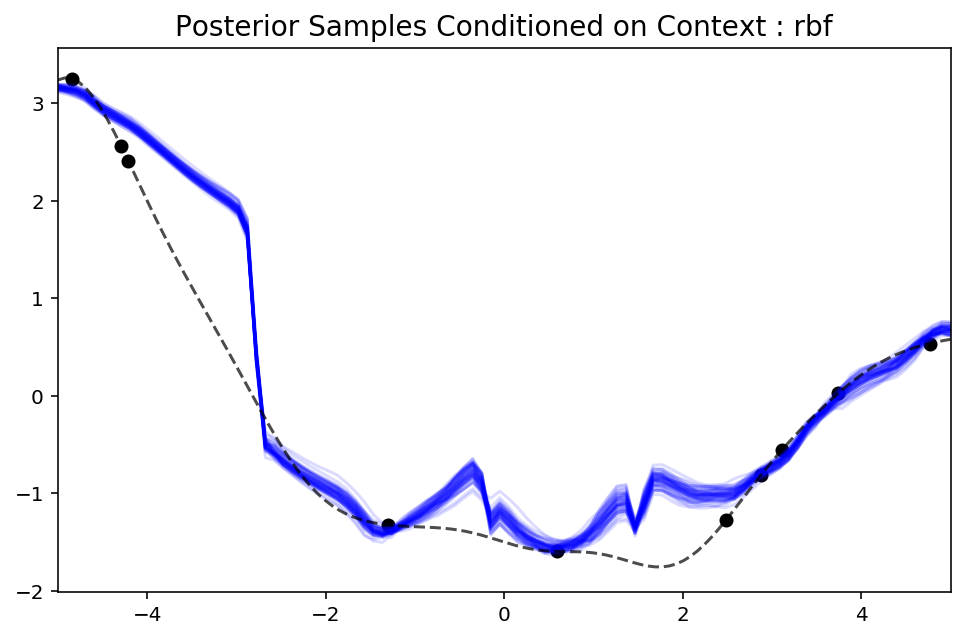

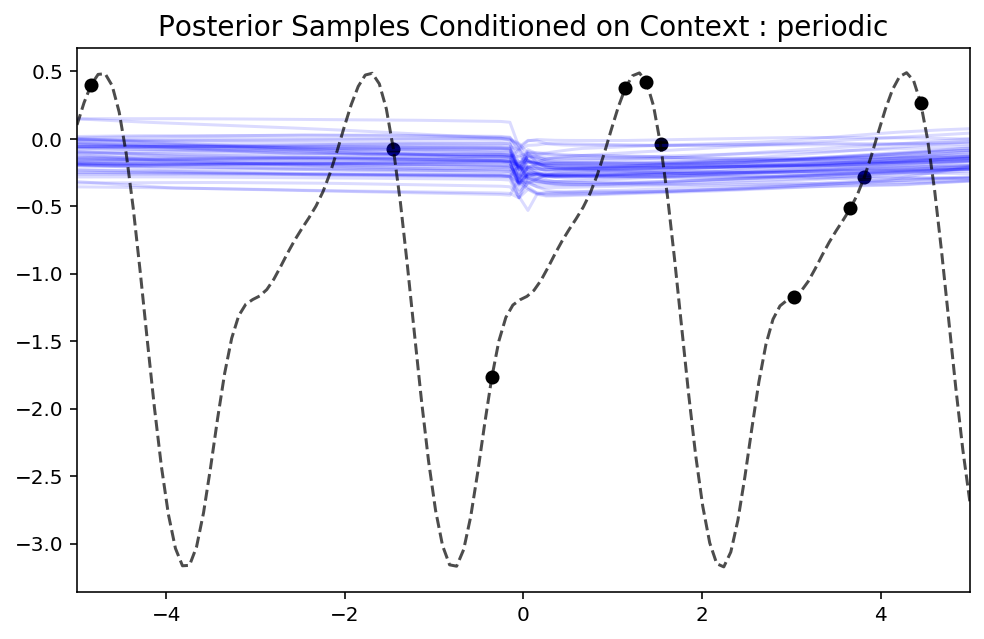

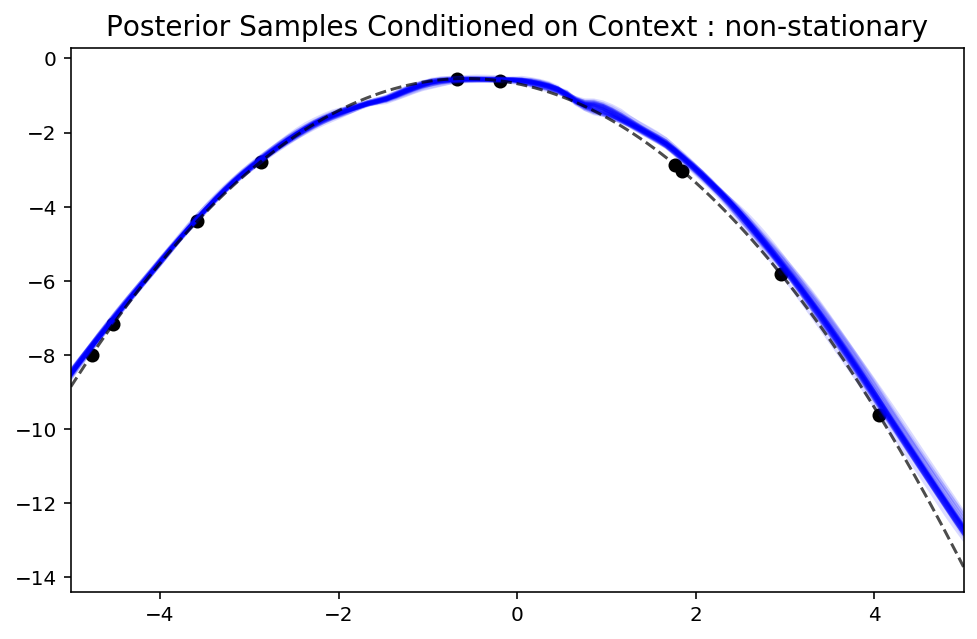

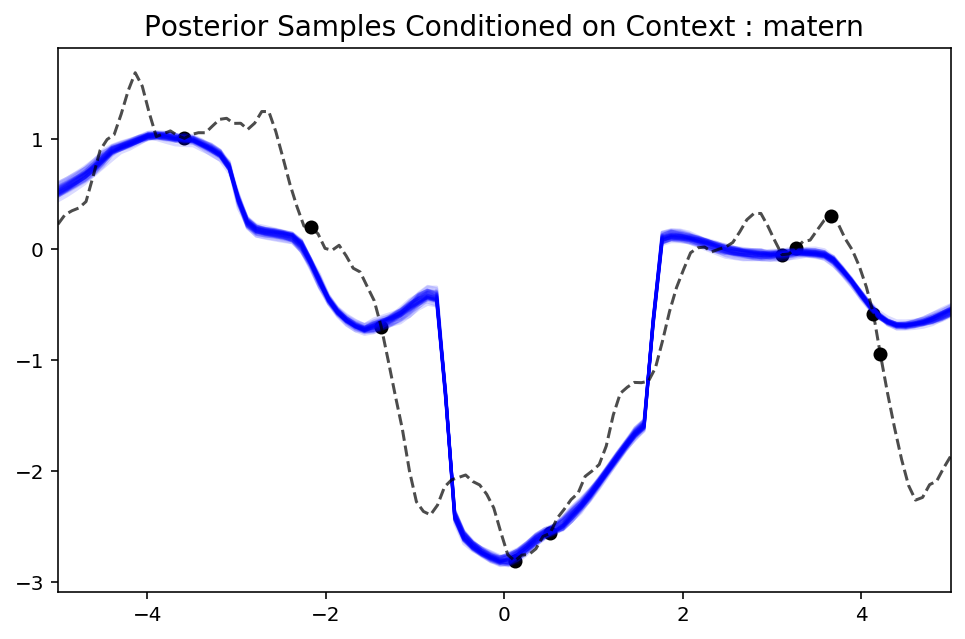

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 2.1738005
std: 0.43083876
std: 1.4389429
std: 5.4705477


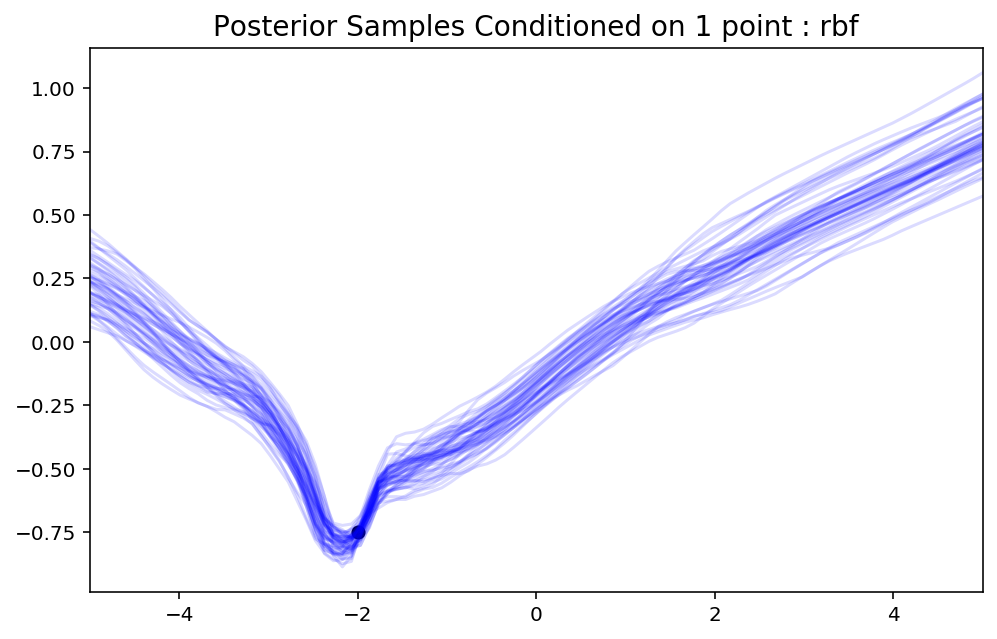

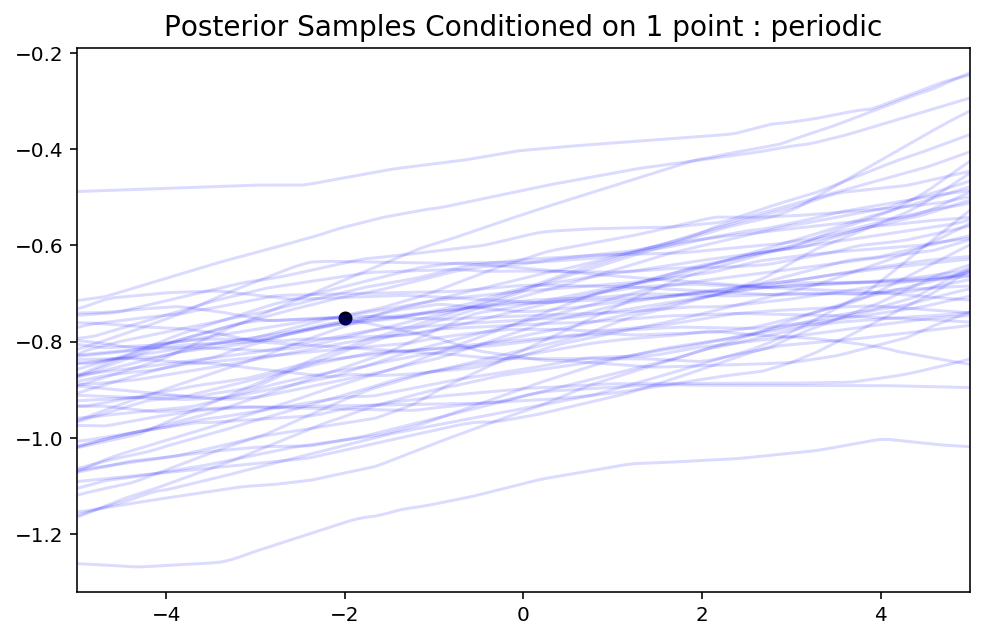

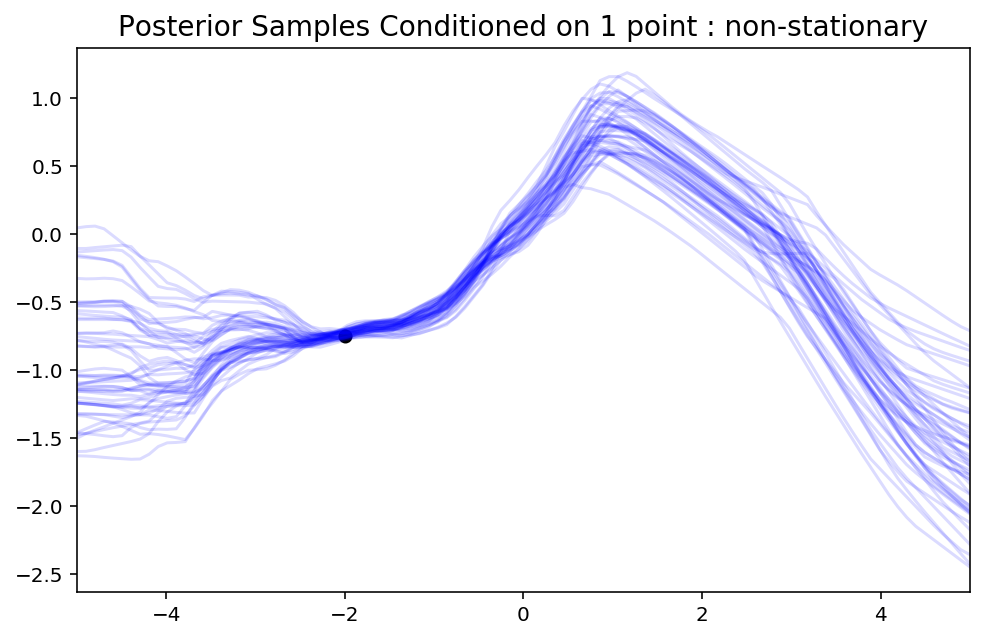

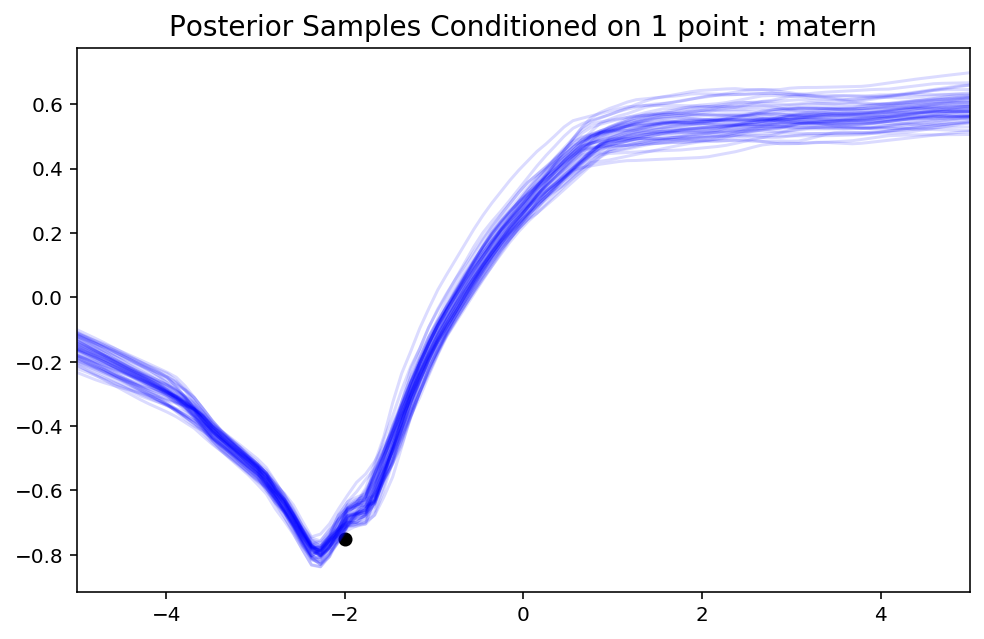

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 2.20875
std: 0.46069062
std: 1.6305625
std: 5.8792443


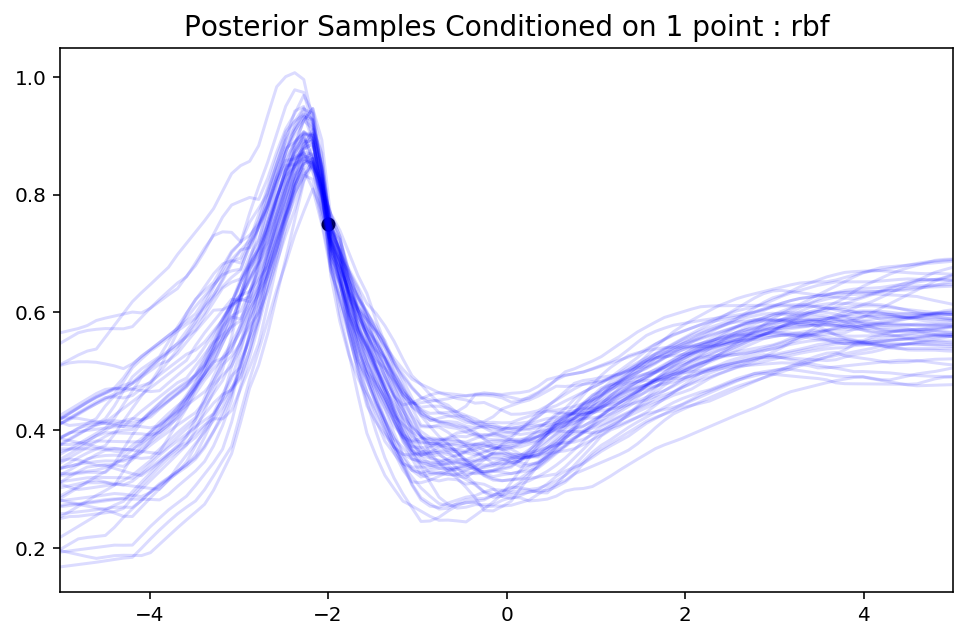

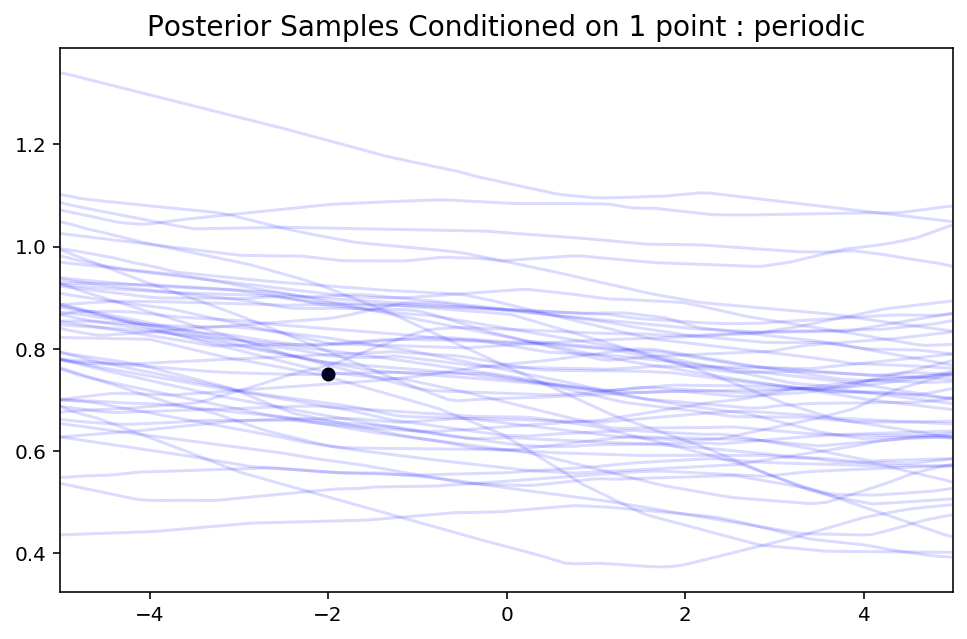

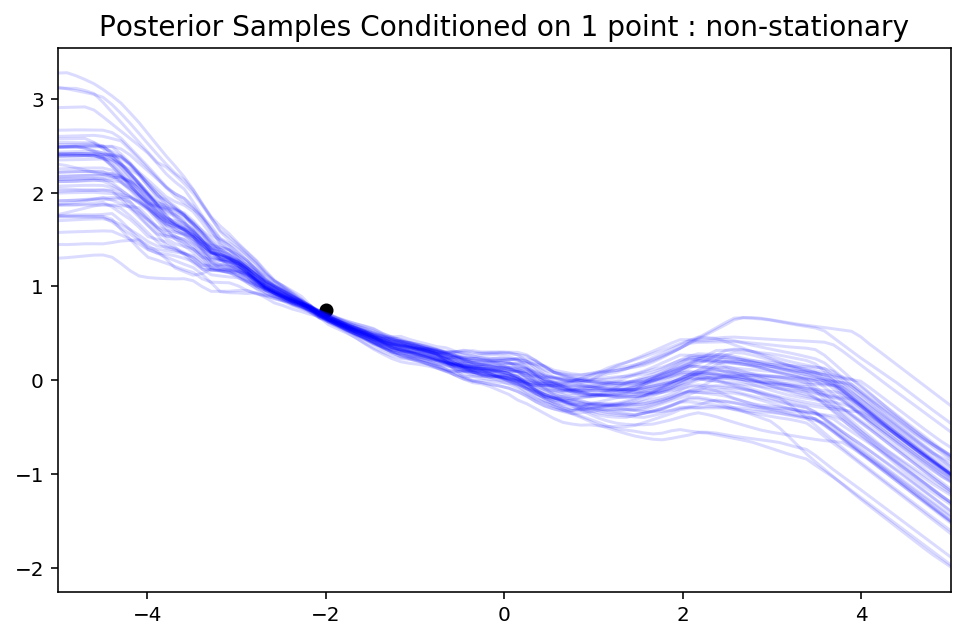

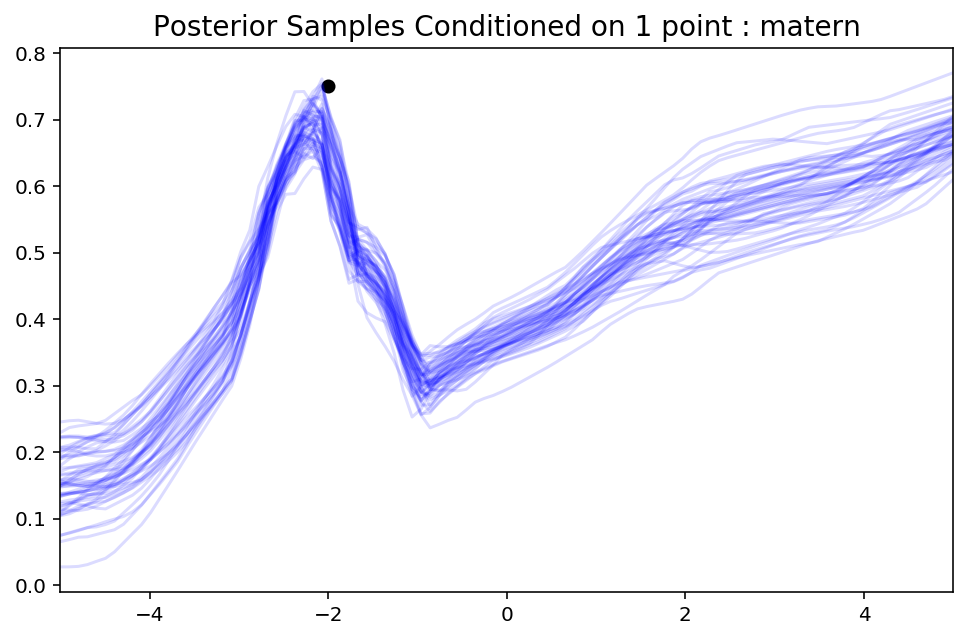

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))